In [52]:
import pandas as pd
from functools import partial
from collections import Counter
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

In [49]:
wdata = pd.read_csv('data/Dataset.csv')

In [53]:
def simplified_quality(q, n):
    
    if n == 3:
        if q <= 4:
            return 0
        elif q <= 6:
            return 1
        else:
            return 2
    elif n == 2:
        if q <= 6:
            return 0
        else:
            return 1

squality = partial(simplified_quality, n=2)

scenarios = {'red': ['red'], 'white': ['white'], 
             'red_and_white': 'red white'.split()}

classifiers = {'randomforestclassifier': {'cls': RandomForestClassifier(),
                                          'pars': {'n_estimators': [50, 200, 400],
                                                    'max_depth': [None, 2, 3, 4],
                                                    'class_weight': ['balanced', None]}},
              'gradientboostingclassifier': {'cls': GradientBoostingClassifier(),
                                            'pars': {'learning_rate': [1e-3,1e-2,1e-1],
                                                     'n_estimators': [100,200,400]}},
              'adaboostclassifier': {'cls': AdaBoostClassifier(),
                                        'pars': {'learning_rate': [1e-3,1e-2,1e-1],
                                                     'n_estimators': [100,200,400]}}}
sm = RandomOverSampler(random_state=499)

for style in scenarios:
    
    X = wdata[wdata['style'].isin(scenarios[style])].drop(['style','quality'], axis=1)
    y = wdata[wdata['style'].isin(scenarios[style])]['quality']
    
    # oversampling
    X_res, y_res = sm.fit_sample(X, y)
    
    X = pd.DataFrame(X_res, columns=X.columns)
    y = pd.Series(y_res)
    
    print(f'\n{style.upper()} wines: {len(X)} samples\n')
    
    print(f'ratings: {Counter(y).most_common()}')
    
    y = y.apply(squality)
    
    print(f'simplified ratings: {Counter(y).most_common()}')

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=471)
    
    for c_ in classifiers:
        
        print(f'\n---> running {c_.upper()}...\n')
        
        pipe = make_pipeline(Normalizer(), classifiers[c_]['cls'])
        
        
        parameters = {f'{c_}__{p_}': classifiers[c_]['pars'][p_]
                                      for p_ in classifiers[c_]['pars']}

        clf = GridSearchCV(pipe, parameters)
        clf.fit(X_train, y_train)

        yh = clf.predict(X_test)

        print(classification_report(y_test, yh))

        ranked_features = sorted([(f, im) for f, im in zip(X_train.columns, 
                 clf.best_estimator_.named_steps[c_].feature_importances_)],
                   key=lambda x: x[1], reverse=True)
        print(f'\nconfusion matrix:\n')
        print(confusion_matrix(y_test, yh))

        print(pd.DataFrame.from_records(ranked_features, columns=['feature', 'weight']))


RED wines: 4086 samples

ratings: [(5, 681), (6, 681), (7, 681), (4, 681), (8, 681), (3, 681)]
simplified ratings: [(0, 2724), (1, 1362)]

---> running RANDOMFORESTCLASSIFIER...

             precision    recall  f1-score   support

          0       0.99      0.97      0.98       668
          1       0.95      0.98      0.97       354

avg / total       0.98      0.98      0.98      1022


confusion matrix:

[[651  17]
 [  6 348]]
                 feature    weight
0       volatile_acidity  0.156834
1            citric_acid  0.156062
2              chlorides  0.126342
3              sulphates  0.107733
4                alcohol  0.091472
5   total_sulfur_dioxide  0.077050
6          fixed_acidity  0.061383
7         residual_sugar  0.057611
8                density  0.056979
9                     pH  0.054277
10   free_sulfur_dioxide  0.054258

---> running GRADIENTBOOSTINGCLASSIFIER...

             precision    recall  f1-score   support

          0       0.98      0.96      0.97 

In [54]:
wdata.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,style
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [63]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [64]:
%matplotlib inline

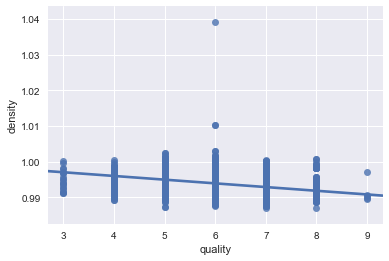

In [83]:
red_chlorides = sns.regplot(x="quality", y="density", data=wdata[wdata['style'] == 'white']);

In [84]:
red_chlorides.get_figure().savefig("white_density.png")